import

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import statistics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

function

In [79]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP

In [80]:
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity

In [81]:
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity

In [82]:
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy

In [83]:
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision

In [84]:
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1

parameter1 split1

In [85]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


In [86]:
# grid search logistic regression model

# define model
model = LogisticRegression()

# define parameter range
param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'penalty' : ['l2'],
              'C' : np.logspace(-4, 4, 50),
              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
result = search.fit(x_val, y_val)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9888888888888889
Best Hyperparameters: {'C': 0.08685113737513521, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [87]:
# create the individual models
model = LogisticRegression(C=0.08685113737513521, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

split1
############## validate set ################
Confusion Matrix
----------------
[[47  5]
 [ 1 38]] 

----------------
Sensitivity: 97.44%
Specificity: 90.38%
Accuracy: 93.41%
Precision: 88.37%
Sensitivity: 97.44%
Precision: 88.37%
F1: 92.68%


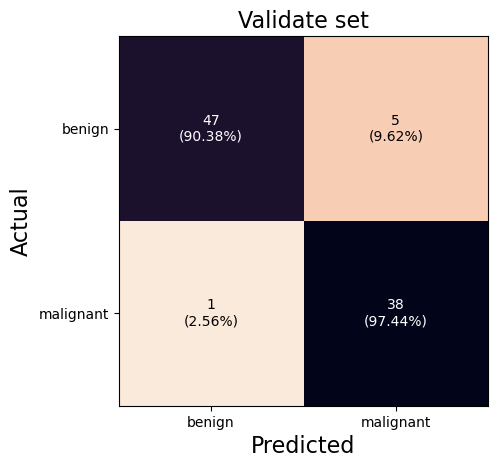

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 96.49%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


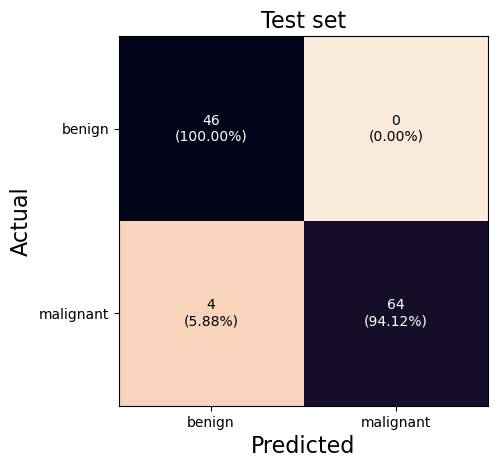

---------------------------------------
AUC validate: 0.9391
AUC test: 0.9706


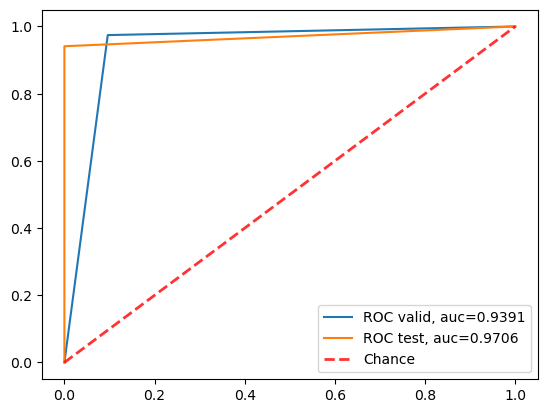

In [88]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [89]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


split2
############## validate set ################
Confusion Matrix
----------------
[[50  3]
 [ 2 36]] 

----------------
Sensitivity: 94.74%
Specificity: 94.34%
Accuracy: 94.51%
Precision: 92.31%
Sensitivity: 94.74%
Precision: 92.31%
F1: 93.51%


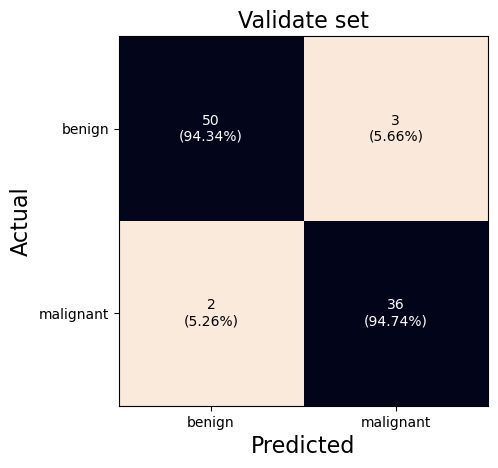

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 96.49%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


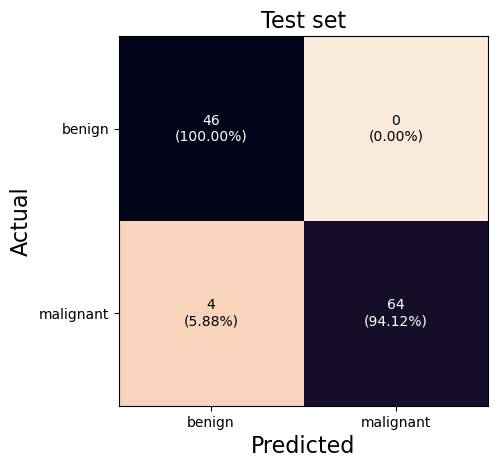

---------------------------------------
AUC validate: 0.9454
AUC test: 0.9706


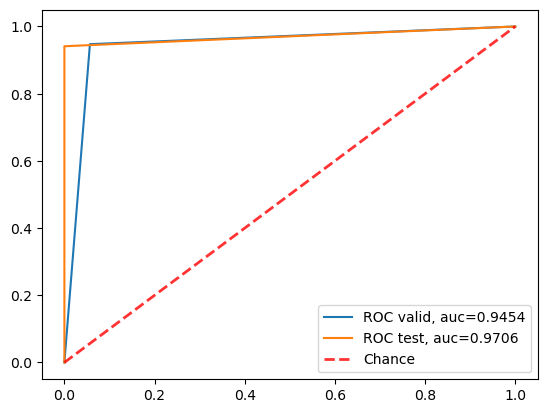

In [90]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [91]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


split3
############## validate set ################
Confusion Matrix
----------------
[[59  7]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 89.39%
Accuracy: 91.21%
Precision: 77.42%
Sensitivity: 96.00%
Precision: 77.42%
F1: 85.71%


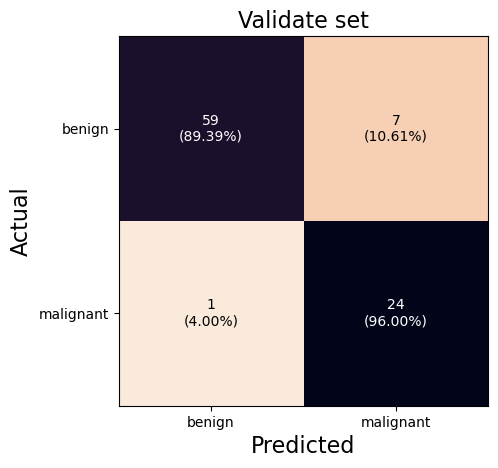

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 96.49%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


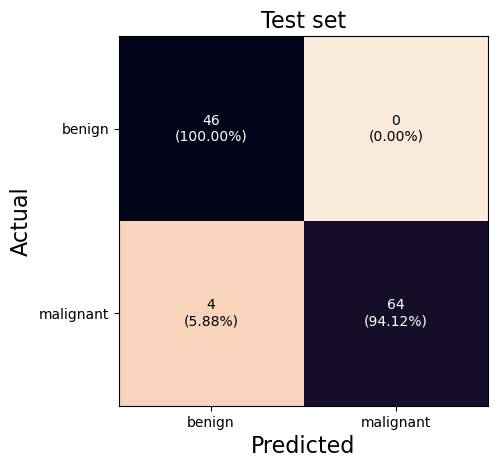

---------------------------------------
AUC validate: 0.9270
AUC test: 0.9706


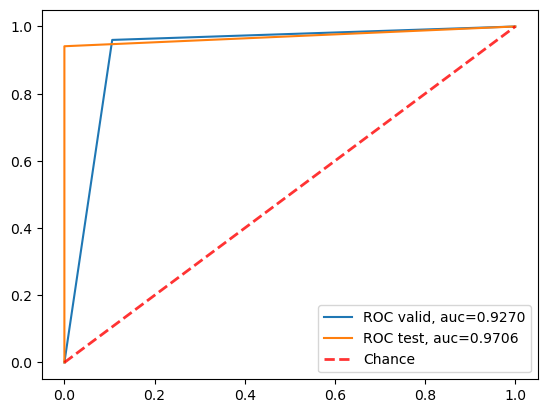

In [92]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [93]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


split4
############## validate set ################
Confusion Matrix
----------------
[[54 18]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 75.00%
Accuracy: 80.22%
Precision: 51.35%
Sensitivity: 100.00%
Precision: 51.35%
F1: 67.86%


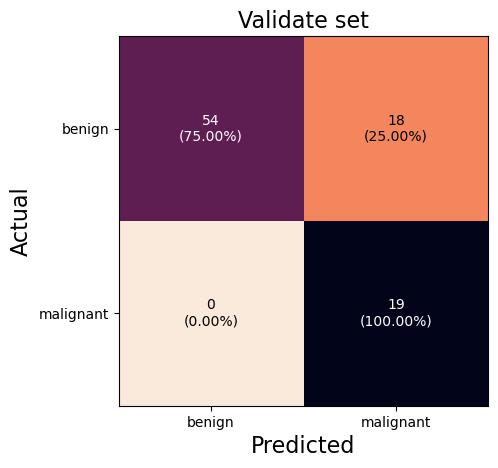

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 100.00%
Accuracy: 97.37%
Precision: 100.00%
Sensitivity: 95.59%
Precision: 100.00%
F1: 97.74%


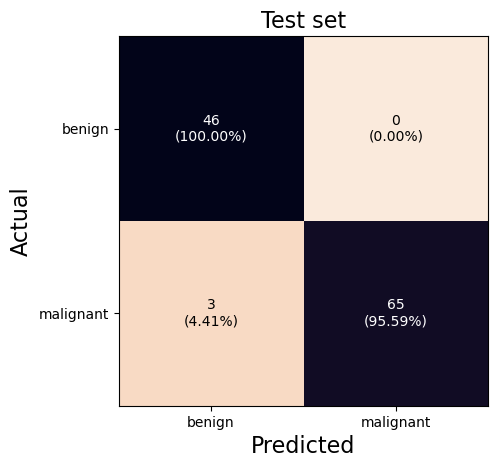

---------------------------------------
AUC validate: 0.8750
AUC test: 0.9779


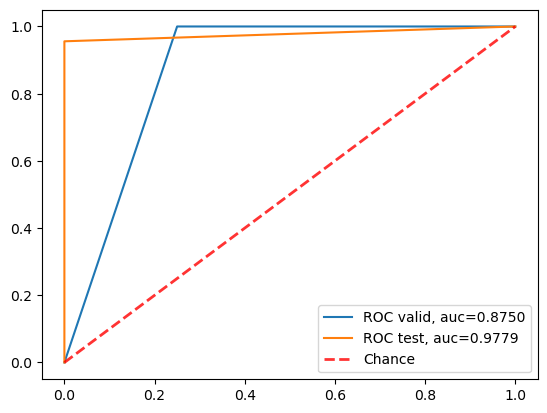

In [94]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [95]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param1/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


split5
############## validate set ################
Confusion Matrix
----------------
[[50 18]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 73.53%
Accuracy: 80.22%
Precision: 56.10%
Sensitivity: 100.00%
Precision: 56.10%
F1: 71.88%


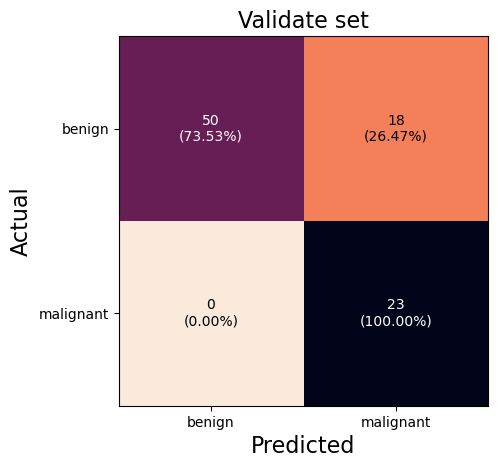

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


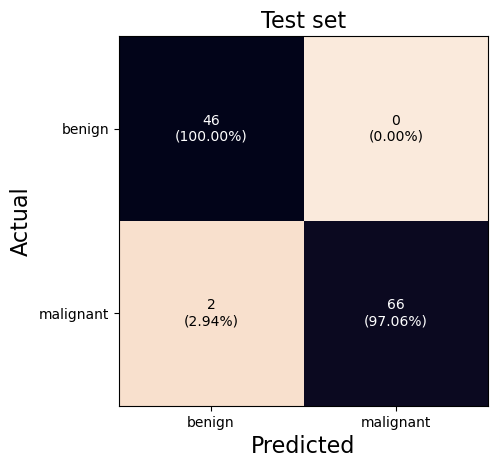

---------------------------------------
AUC validate: 0.8676
AUC test: 0.9853


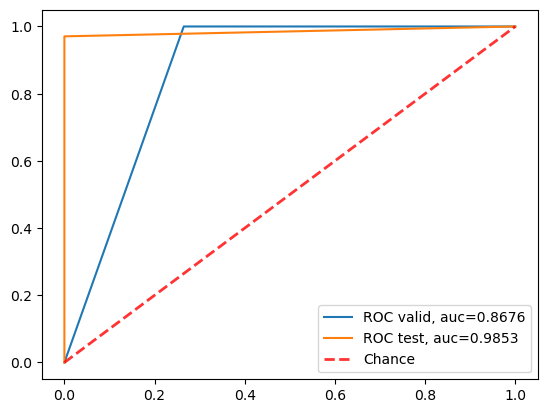

In [96]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [97]:
sensitivity_values = []

sensitivity_values.append(sen_test_split1)
sensitivity_values.append(sen_test_split2)
sensitivity_values.append(sen_test_split3)
sensitivity_values.append(sen_test_split4)
sensitivity_values.append(sen_test_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_test_split1)
specificity_values.append(spec_test_split2)
specificity_values.append(spec_test_split3)
specificity_values.append(spec_test_split4)
specificity_values.append(spec_test_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_test_split1)
accuracy_values.append(acc_test_split2)
accuracy_values.append(acc_test_split3)
accuracy_values.append(acc_test_split4)
accuracy_values.append(acc_test_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_test_split1)
precision_values.append(pre_test_split2)
precision_values.append(pre_test_split3)
precision_values.append(pre_test_split4)
precision_values.append(pre_test_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_test_split1)
f1_values.append(f1_test_split2)
f1_values.append(f1_test_split3)
f1_values.append(f1_test_split4)
f1_values.append(f1_test_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_test_split1)
auc_values.append(auc_test_split2)
auc_values.append(auc_test_split3)
auc_values.append(auc_test_split4)
auc_values.append(auc_test_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc, auc_sd))

[94.11764705882352, 94.11764705882352, 94.11764705882352, 95.58823529411765, 97.05882352941177]
Mean Sensitivity: 95.0
Sensitivity Standard Deviation: 1.3153341044116467
Overall Sensitivity: 95.00 ± 1.32%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean Specificity: 100.0
Specificity Standard Deviation: 0.0
Overall Specificity: 100.00 ± 0.00%
[96.49122807017544, 96.49122807017544, 96.49122807017544, 97.36842105263158, 98.24561403508771]
Mean accuracy: 97.01754385964912
accuracy Standard Deviation: 0.784585255263081
Overall accuracy: 97.02 ± 0.78%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean precision: 100.0
precision Standard Deviation: 0.0
Overall precision: 100.00 ± 0.00%
[96.96969696969695, 96.96969696969695, 96.96969696969695, 97.74436090225565, 98.50746268656717]
Mean f1: 97.43218289958274
f1 Standard Deviation: 0.6883606307156662
Overall f1: 97.43 ± 0.69%
[0.9705882352941176, 0.9705882352941176, 0.9705882352941176, 0.9779411764705883, 0.9852941176470589]
Mean auc: 0.975
auc Standard Deviatio

parameter2 split2

In [98]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


In [99]:
# grid search logistic regression model

# define model
model = LogisticRegression()

# define parameter range
param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'penalty' : ['l2'],
              'C' : np.logspace(-4, 4, 50),
              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
result = search.fit(x_val, y_val)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9456140350877194
Best Hyperparameters: {'C': 0.5689866029018293, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}


In [100]:
# create the individual models
model = LogisticRegression(C=0.5689866029018293, max_iter=1000, penalty='l2', solver='sag')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

split2
############## validate set ################
Confusion Matrix
----------------
[[49  4]
 [ 2 36]] 

----------------
Sensitivity: 94.74%
Specificity: 92.45%
Accuracy: 93.41%
Precision: 90.00%
Sensitivity: 94.74%
Precision: 90.00%
F1: 92.31%


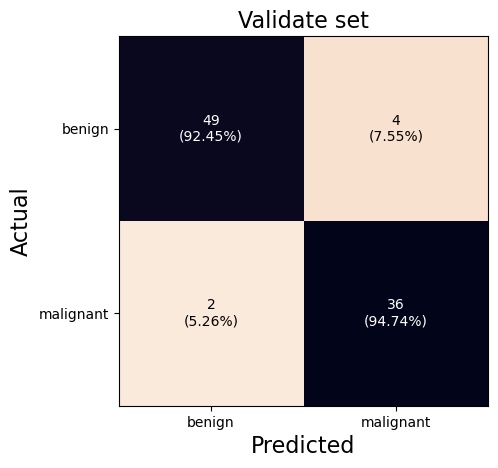

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 7 61]] 

----------------
Sensitivity: 89.71%
Specificity: 100.00%
Accuracy: 93.86%
Precision: 100.00%
Sensitivity: 89.71%
Precision: 100.00%
F1: 94.57%


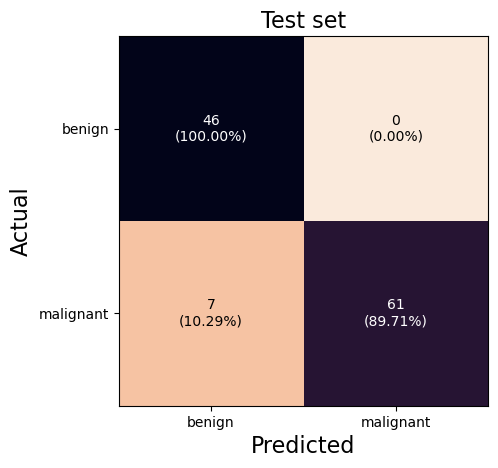

---------------------------------------
AUC validate: 0.9359
AUC test: 0.9485


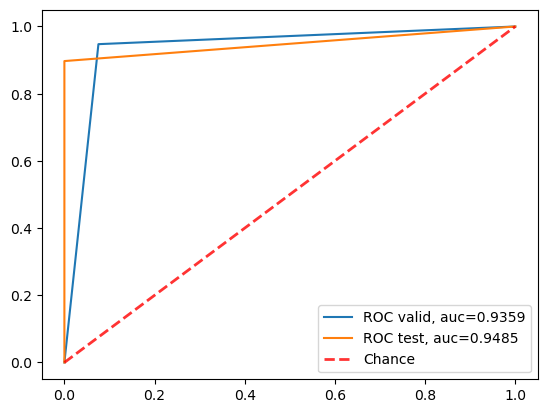

In [101]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [102]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


split1
############## validate set ################
Confusion Matrix
----------------
[[45  7]
 [ 1 38]] 

----------------
Sensitivity: 97.44%
Specificity: 86.54%
Accuracy: 91.21%
Precision: 84.44%
Sensitivity: 97.44%
Precision: 84.44%
F1: 90.48%


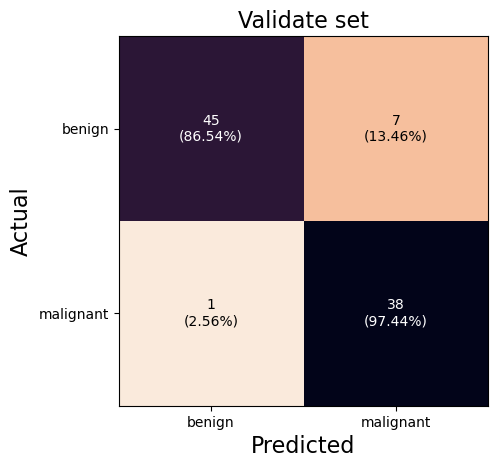

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 6 62]] 

----------------
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 94.74%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%


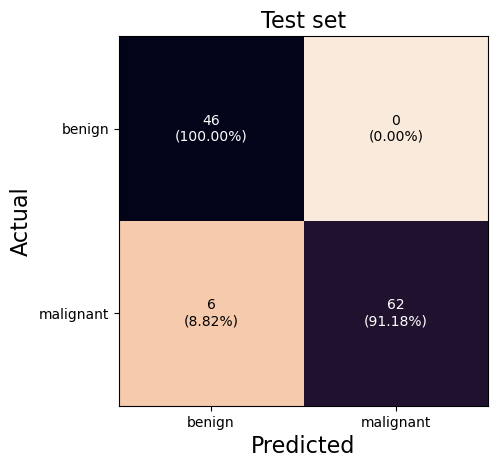

---------------------------------------
AUC validate: 0.9199
AUC test: 0.9559


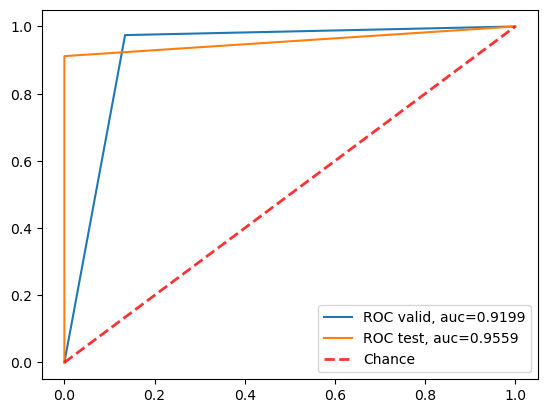

In [103]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [104]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


split3
############## validate set ################
Confusion Matrix
----------------
[[58  8]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 87.88%
Accuracy: 90.11%
Precision: 75.00%
Sensitivity: 96.00%
Precision: 75.00%
F1: 84.21%


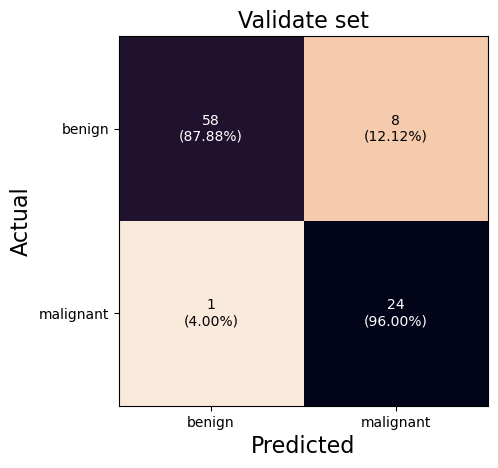

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 100.00%
Accuracy: 97.37%
Precision: 100.00%
Sensitivity: 95.59%
Precision: 100.00%
F1: 97.74%


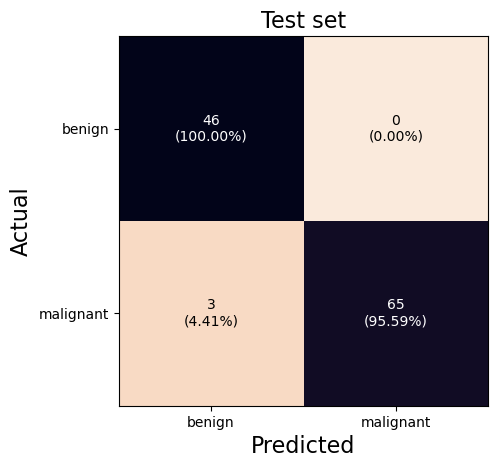

---------------------------------------
AUC validate: 0.9194
AUC test: 0.9779


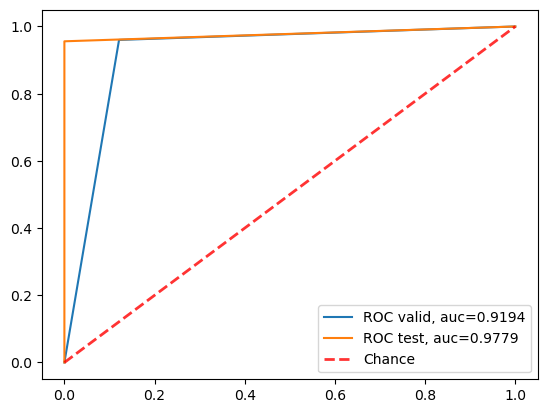

In [105]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [106]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


split4
############## validate set ################
Confusion Matrix
----------------
[[52 20]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 72.22%
Accuracy: 78.02%
Precision: 48.72%
Sensitivity: 100.00%
Precision: 48.72%
F1: 65.52%


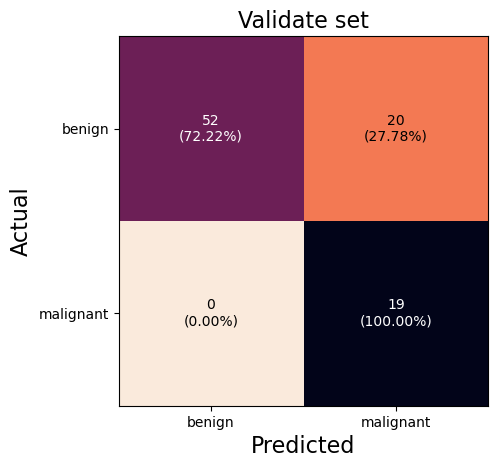

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


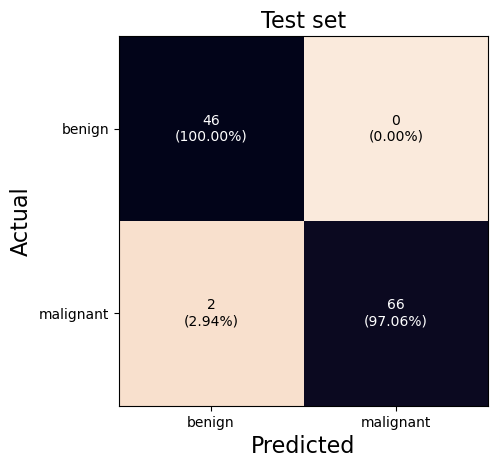

---------------------------------------
AUC validate: 0.8611
AUC test: 0.9853


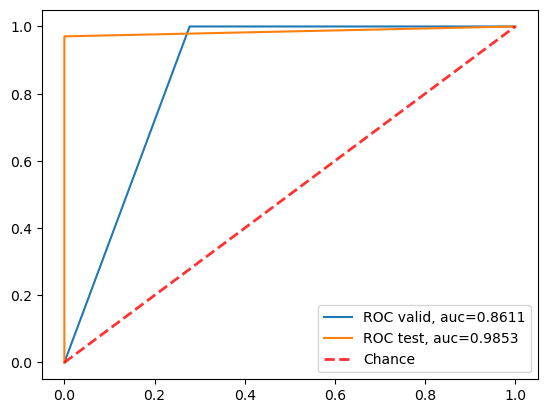

In [107]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [108]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param2/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


split5
############## validate set ################
Confusion Matrix
----------------
[[46 22]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 67.65%
Accuracy: 75.82%
Precision: 51.11%
Sensitivity: 100.00%
Precision: 51.11%
F1: 67.65%


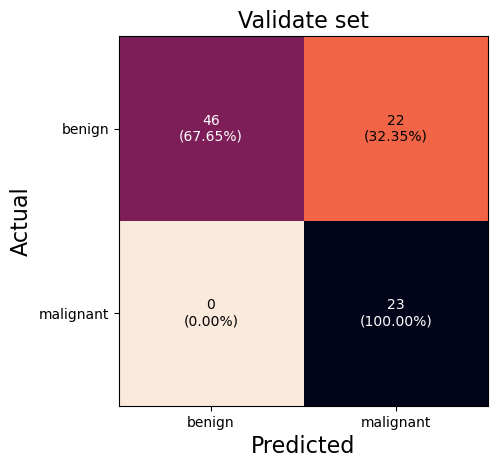

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


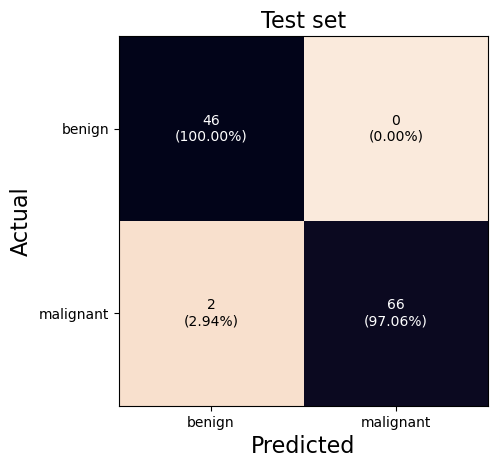

---------------------------------------
AUC validate: 0.8382
AUC test: 0.9853


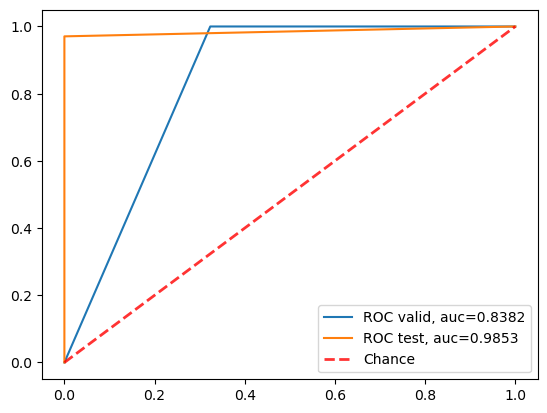

In [109]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [110]:
sensitivity_values = []

sensitivity_values.append(sen_test_split1)
sensitivity_values.append(sen_test_split2)
sensitivity_values.append(sen_test_split3)
sensitivity_values.append(sen_test_split4)
sensitivity_values.append(sen_test_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_test_split1)
specificity_values.append(spec_test_split2)
specificity_values.append(spec_test_split3)
specificity_values.append(spec_test_split4)
specificity_values.append(spec_test_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_test_split1)
accuracy_values.append(acc_test_split2)
accuracy_values.append(acc_test_split3)
accuracy_values.append(acc_test_split4)
accuracy_values.append(acc_test_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_test_split1)
precision_values.append(pre_test_split2)
precision_values.append(pre_test_split3)
precision_values.append(pre_test_split4)
precision_values.append(pre_test_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_test_split1)
f1_values.append(f1_test_split2)
f1_values.append(f1_test_split3)
f1_values.append(f1_test_split4)
f1_values.append(f1_test_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_test_split1)
auc_values.append(auc_test_split2)
auc_values.append(auc_test_split3)
auc_values.append(auc_test_split4)
auc_values.append(auc_test_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc, auc_sd))

[91.17647058823529, 89.70588235294117, 95.58823529411765, 97.05882352941177, 97.05882352941177]
Mean Sensitivity: 94.11764705882354
Sensitivity Standard Deviation: 3.4488351175172314
Overall Sensitivity: 94.12 ± 3.45%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean Specificity: 100.0
Specificity Standard Deviation: 0.0
Overall Specificity: 100.00 ± 0.00%
[94.73684210526315, 93.85964912280701, 97.36842105263158, 98.24561403508771, 98.24561403508771]
Mean accuracy: 96.49122807017544
accuracy Standard Deviation: 2.0571998946593983
Overall accuracy: 96.49 ± 2.06%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean precision: 100.0
precision Standard Deviation: 0.0
Overall precision: 100.00 ± 0.00%
[95.38461538461539, 94.57364341085271, 97.74436090225565, 98.50746268656717, 98.50746268656717]
Mean f1: 96.94350901417161
f1 Standard Deviation: 1.842530749506768
Overall f1: 96.94 ± 1.84%
[0.9558823529411764, 0.9485294117647058, 0.9779411764705883, 0.9852941176470589, 0.9852941176470589]
Mean auc: 0.970588235294

parameter3 split3

In [111]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


In [112]:
# grid search logistic regression model

# define model
model = LogisticRegression()

# define parameter range
param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'penalty' : ['l2'],
              'C' : np.logspace(-4, 4, 50),
              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
result = search.fit(x_val, y_val)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9783625730994151
Best Hyperparameters: {'C': 0.05963623316594643, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [113]:
# create the individual models
model = LogisticRegression(C=0.05963623316594643, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

split3
############## validate set ################
Confusion Matrix
----------------
[[59  7]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 89.39%
Accuracy: 91.21%
Precision: 77.42%
Sensitivity: 96.00%
Precision: 77.42%
F1: 85.71%


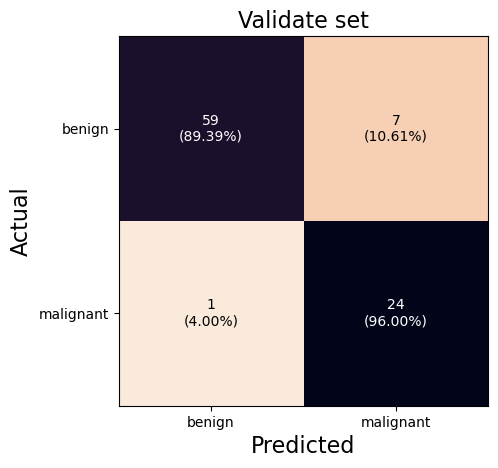

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 96.49%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


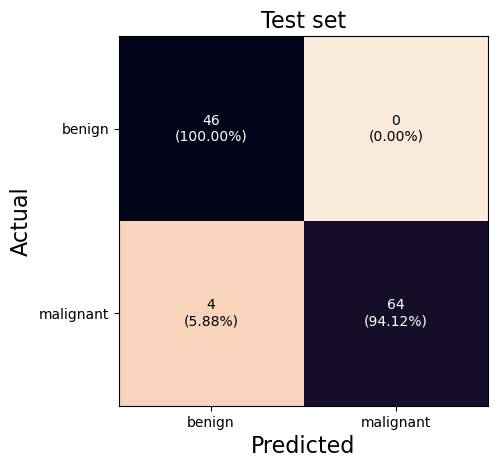

---------------------------------------
AUC validate: 0.9270
AUC test: 0.9706


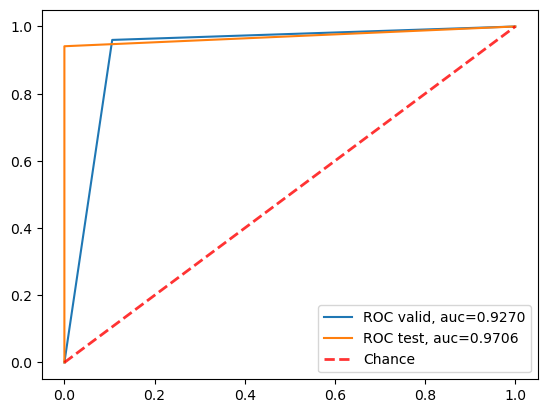

In [114]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [115]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


split1
############## validate set ################
Confusion Matrix
----------------
[[47  5]
 [ 1 38]] 

----------------
Sensitivity: 97.44%
Specificity: 90.38%
Accuracy: 93.41%
Precision: 88.37%
Sensitivity: 97.44%
Precision: 88.37%
F1: 92.68%


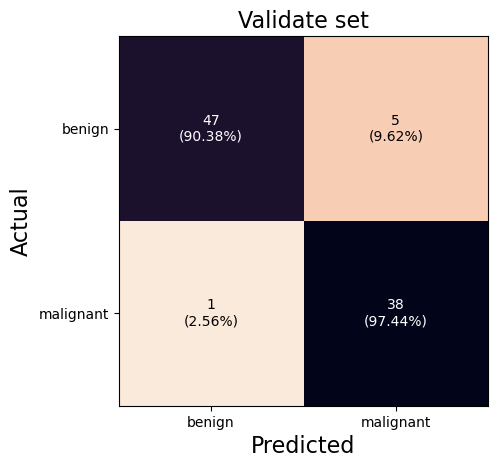

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 96.49%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


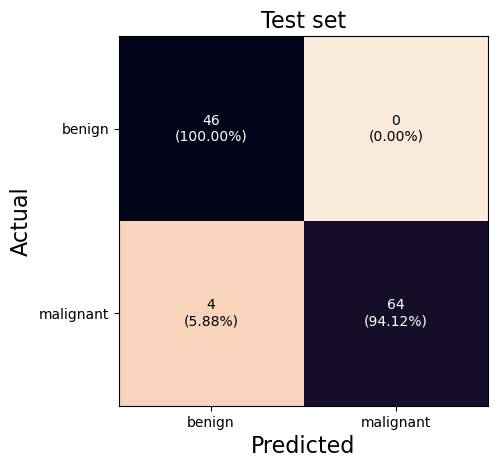

---------------------------------------
AUC validate: 0.9391
AUC test: 0.9706


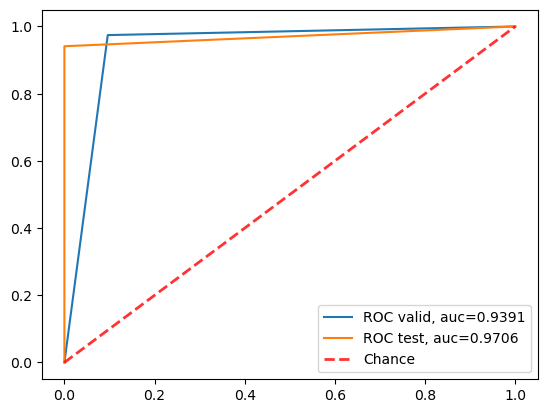

In [116]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [117]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


split2
############## validate set ################
Confusion Matrix
----------------
[[50  3]
 [ 2 36]] 

----------------
Sensitivity: 94.74%
Specificity: 94.34%
Accuracy: 94.51%
Precision: 92.31%
Sensitivity: 94.74%
Precision: 92.31%
F1: 93.51%


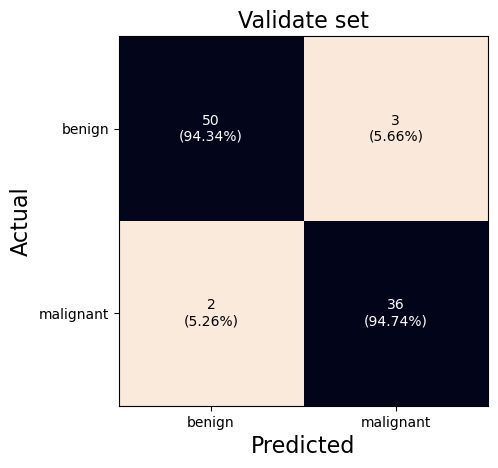

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 96.49%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


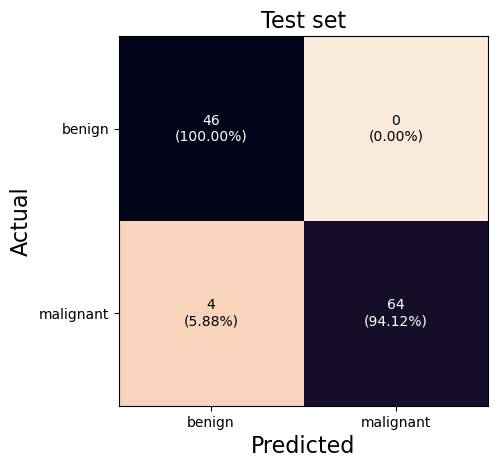

---------------------------------------
AUC validate: 0.9454
AUC test: 0.9706


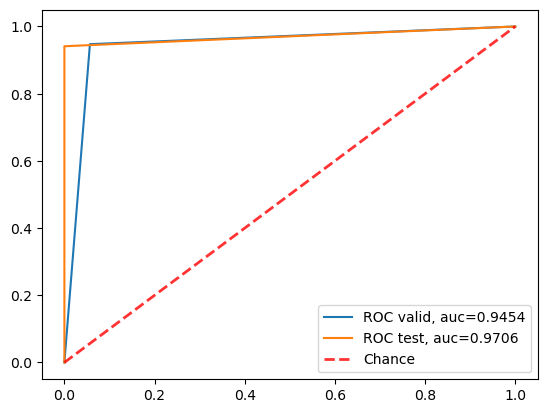

In [118]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [119]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


split4
############## validate set ################
Confusion Matrix
----------------
[[57 15]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 79.17%
Accuracy: 83.52%
Precision: 55.88%
Sensitivity: 100.00%
Precision: 55.88%
F1: 71.70%


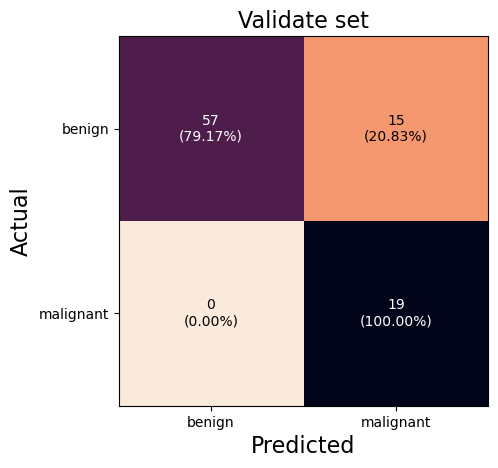

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 100.00%
Accuracy: 97.37%
Precision: 100.00%
Sensitivity: 95.59%
Precision: 100.00%
F1: 97.74%


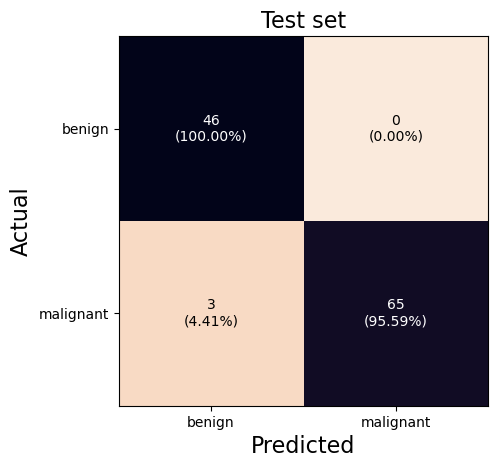

---------------------------------------
AUC validate: 0.8958
AUC test: 0.9779


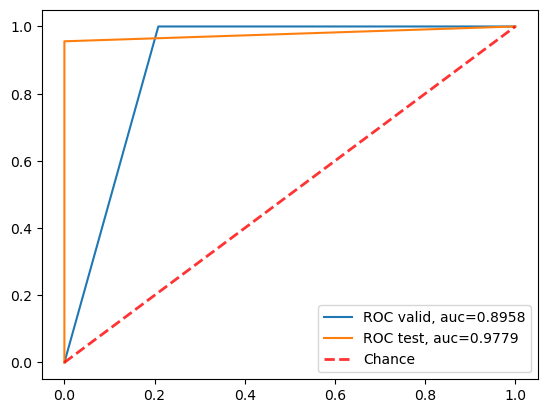

In [120]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [121]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param3/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


split5
############## validate set ################
Confusion Matrix
----------------
[[50 18]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 73.53%
Accuracy: 80.22%
Precision: 56.10%
Sensitivity: 100.00%
Precision: 56.10%
F1: 71.88%


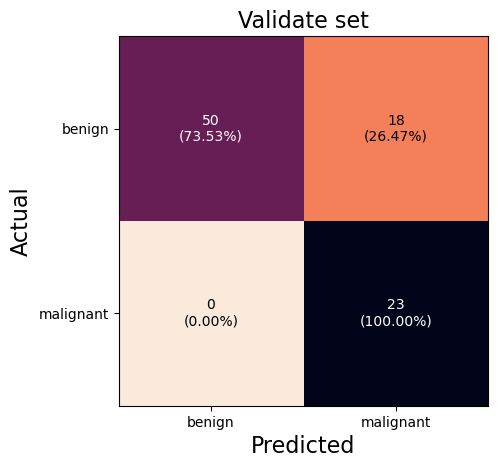

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


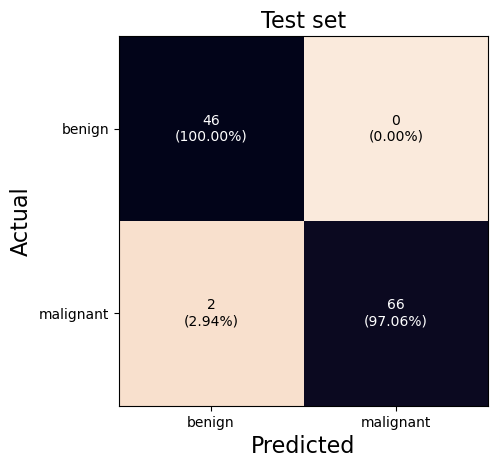

---------------------------------------
AUC validate: 0.8676
AUC test: 0.9853


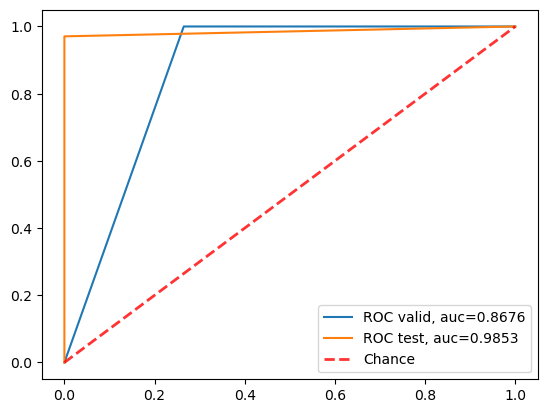

In [122]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [123]:
sensitivity_values = []

sensitivity_values.append(sen_test_split1)
sensitivity_values.append(sen_test_split2)
sensitivity_values.append(sen_test_split3)
sensitivity_values.append(sen_test_split4)
sensitivity_values.append(sen_test_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_test_split1)
specificity_values.append(spec_test_split2)
specificity_values.append(spec_test_split3)
specificity_values.append(spec_test_split4)
specificity_values.append(spec_test_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_test_split1)
accuracy_values.append(acc_test_split2)
accuracy_values.append(acc_test_split3)
accuracy_values.append(acc_test_split4)
accuracy_values.append(acc_test_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_test_split1)
precision_values.append(pre_test_split2)
precision_values.append(pre_test_split3)
precision_values.append(pre_test_split4)
precision_values.append(pre_test_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_test_split1)
f1_values.append(f1_test_split2)
f1_values.append(f1_test_split3)
f1_values.append(f1_test_split4)
f1_values.append(f1_test_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_test_split1)
auc_values.append(auc_test_split2)
auc_values.append(auc_test_split3)
auc_values.append(auc_test_split4)
auc_values.append(auc_test_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc, auc_sd))

[94.11764705882352, 94.11764705882352, 94.11764705882352, 95.58823529411765, 97.05882352941177]
Mean Sensitivity: 95.0
Sensitivity Standard Deviation: 1.3153341044116467
Overall Sensitivity: 95.00 ± 1.32%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean Specificity: 100.0
Specificity Standard Deviation: 0.0
Overall Specificity: 100.00 ± 0.00%
[96.49122807017544, 96.49122807017544, 96.49122807017544, 97.36842105263158, 98.24561403508771]
Mean accuracy: 97.01754385964912
accuracy Standard Deviation: 0.784585255263081
Overall accuracy: 97.02 ± 0.78%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean precision: 100.0
precision Standard Deviation: 0.0
Overall precision: 100.00 ± 0.00%
[96.96969696969695, 96.96969696969695, 96.96969696969695, 97.74436090225565, 98.50746268656717]
Mean f1: 97.43218289958274
f1 Standard Deviation: 0.6883606307156662
Overall f1: 97.43 ± 0.69%
[0.9705882352941176, 0.9705882352941176, 0.9705882352941176, 0.9779411764705883, 0.9852941176470589]
Mean auc: 0.975
auc Standard Deviatio

parameter4 split4

In [152]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


In [153]:
# grid search logistic regression model

# define model
model = LogisticRegression()

# define parameter range
param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'penalty' : ['l2'],
              'C' : np.logspace(-4, 4, 50),
              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
result = search.fit(x_val, y_val)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9777777777777779
Best Hyperparameters: {'C': 0.5689866029018293, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


In [155]:
# create the individual models
model = LogisticRegression(C=0.5689866029018293, max_iter=1000, penalty='l2', solver='saga')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

split4
############## validate set ################
Confusion Matrix
----------------
[[52 20]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 72.22%
Accuracy: 78.02%
Precision: 48.72%
Sensitivity: 100.00%
Precision: 48.72%
F1: 65.52%


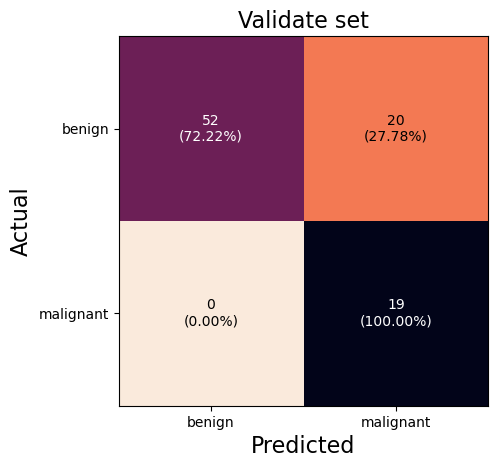

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


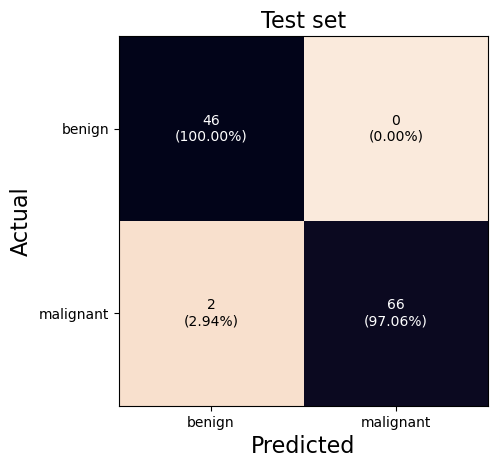

---------------------------------------
AUC validate: 0.8611
AUC test: 0.9853


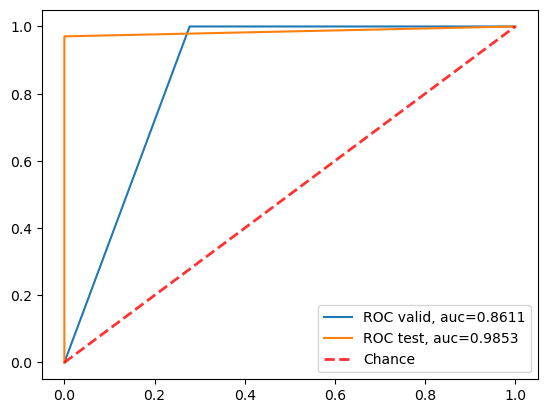

In [156]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [157]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


split1
############## validate set ################
Confusion Matrix
----------------
[[45  7]
 [ 1 38]] 

----------------
Sensitivity: 97.44%
Specificity: 86.54%
Accuracy: 91.21%
Precision: 84.44%
Sensitivity: 97.44%
Precision: 84.44%
F1: 90.48%


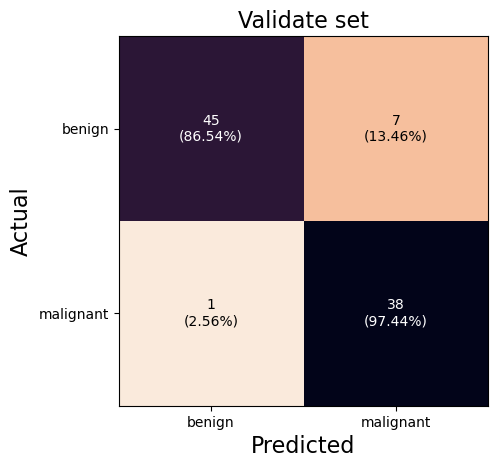

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 6 62]] 

----------------
Sensitivity: 91.18%
Specificity: 100.00%
Accuracy: 94.74%
Precision: 100.00%
Sensitivity: 91.18%
Precision: 100.00%
F1: 95.38%


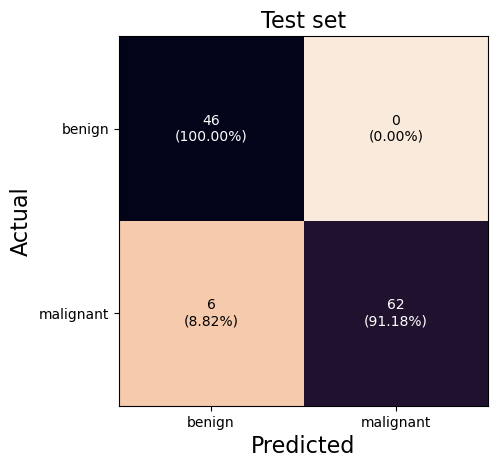

---------------------------------------
AUC validate: 0.9199
AUC test: 0.9559


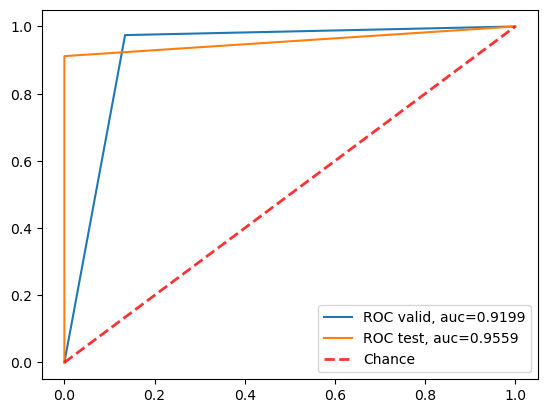

In [158]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [159]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


split2
############## validate set ################
Confusion Matrix
----------------
[[49  4]
 [ 2 36]] 

----------------
Sensitivity: 94.74%
Specificity: 92.45%
Accuracy: 93.41%
Precision: 90.00%
Sensitivity: 94.74%
Precision: 90.00%
F1: 92.31%


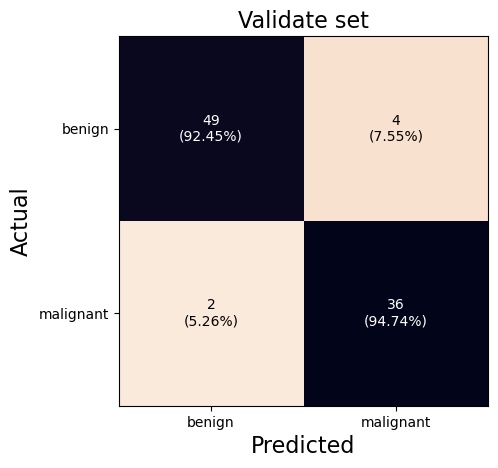

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 7 61]] 

----------------
Sensitivity: 89.71%
Specificity: 100.00%
Accuracy: 93.86%
Precision: 100.00%
Sensitivity: 89.71%
Precision: 100.00%
F1: 94.57%


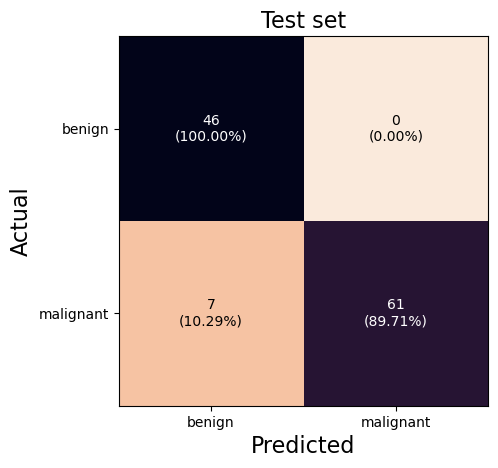

---------------------------------------
AUC validate: 0.9359
AUC test: 0.9485


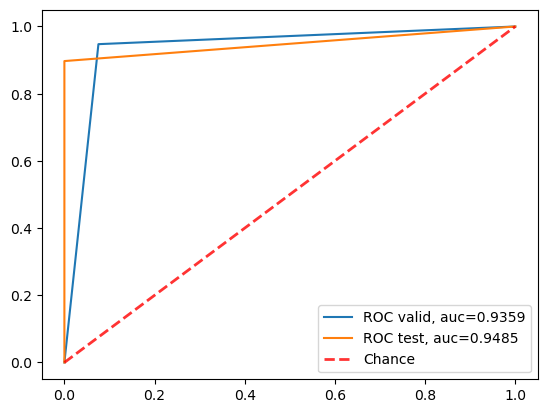

In [160]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [161]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


split3
############## validate set ################
Confusion Matrix
----------------
[[58  8]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 87.88%
Accuracy: 90.11%
Precision: 75.00%
Sensitivity: 96.00%
Precision: 75.00%
F1: 84.21%


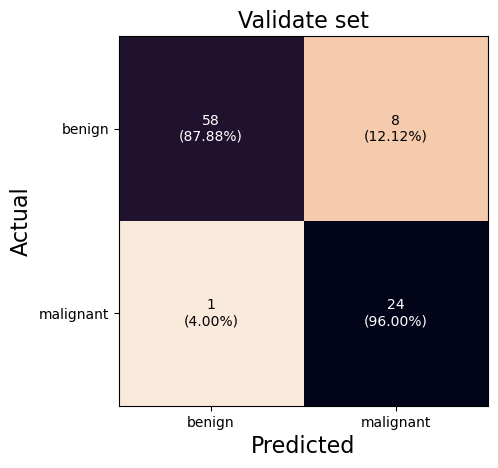

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 100.00%
Accuracy: 97.37%
Precision: 100.00%
Sensitivity: 95.59%
Precision: 100.00%
F1: 97.74%


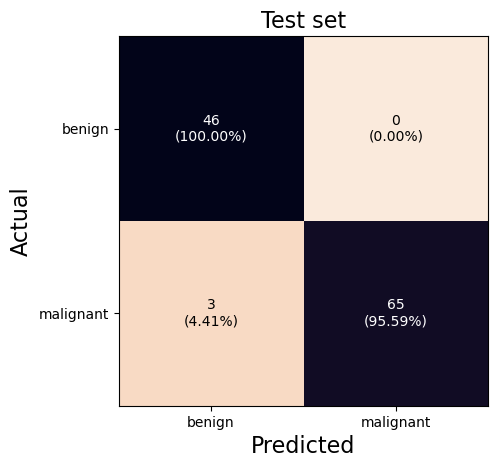

---------------------------------------
AUC validate: 0.9194
AUC test: 0.9779


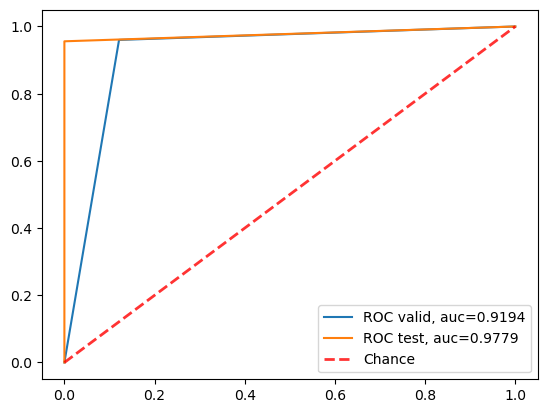

In [162]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split5

In [163]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param4/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


split5
############## validate set ################
Confusion Matrix
----------------
[[46 22]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 67.65%
Accuracy: 75.82%
Precision: 51.11%
Sensitivity: 100.00%
Precision: 51.11%
F1: 67.65%


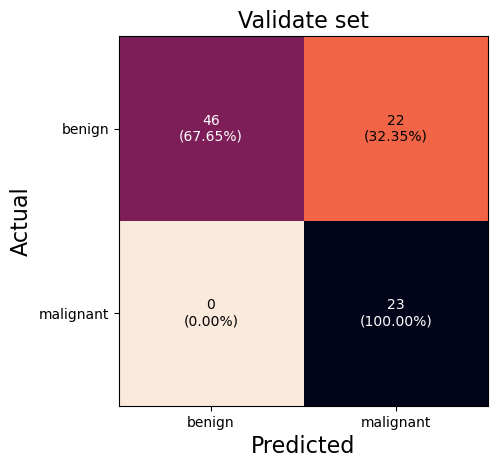

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


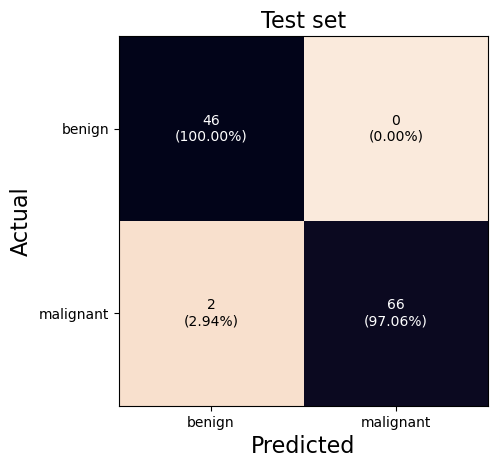

---------------------------------------
AUC validate: 0.8382
AUC test: 0.9853


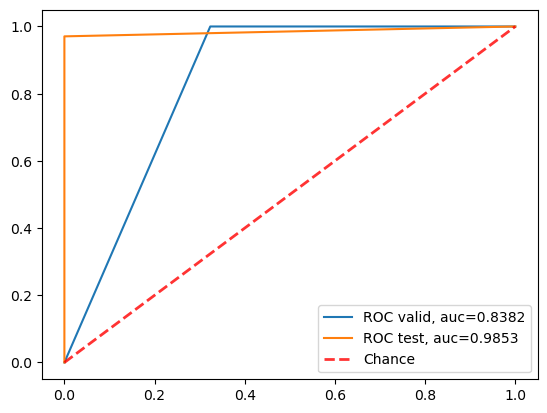

In [164]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [165]:
sensitivity_values = []

sensitivity_values.append(sen_test_split1)
sensitivity_values.append(sen_test_split2)
sensitivity_values.append(sen_test_split3)
sensitivity_values.append(sen_test_split4)
sensitivity_values.append(sen_test_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_test_split1)
specificity_values.append(spec_test_split2)
specificity_values.append(spec_test_split3)
specificity_values.append(spec_test_split4)
specificity_values.append(spec_test_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_test_split1)
accuracy_values.append(acc_test_split2)
accuracy_values.append(acc_test_split3)
accuracy_values.append(acc_test_split4)
accuracy_values.append(acc_test_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_test_split1)
precision_values.append(pre_test_split2)
precision_values.append(pre_test_split3)
precision_values.append(pre_test_split4)
precision_values.append(pre_test_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_test_split1)
f1_values.append(f1_test_split2)
f1_values.append(f1_test_split3)
f1_values.append(f1_test_split4)
f1_values.append(f1_test_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_test_split1)
auc_values.append(auc_test_split2)
auc_values.append(auc_test_split3)
auc_values.append(auc_test_split4)
auc_values.append(auc_test_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc, auc_sd))

[91.17647058823529, 89.70588235294117, 95.58823529411765, 97.05882352941177, 97.05882352941177]
Mean Sensitivity: 94.11764705882354
Sensitivity Standard Deviation: 3.4488351175172314
Overall Sensitivity: 94.12 ± 3.45%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean Specificity: 100.0
Specificity Standard Deviation: 0.0
Overall Specificity: 100.00 ± 0.00%
[94.73684210526315, 93.85964912280701, 97.36842105263158, 98.24561403508771, 98.24561403508771]
Mean accuracy: 96.49122807017544
accuracy Standard Deviation: 2.0571998946593983
Overall accuracy: 96.49 ± 2.06%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean precision: 100.0
precision Standard Deviation: 0.0
Overall precision: 100.00 ± 0.00%
[95.38461538461539, 94.57364341085271, 97.74436090225565, 98.50746268656717, 98.50746268656717]
Mean f1: 96.94350901417161
f1 Standard Deviation: 1.842530749506768
Overall f1: 96.94 ± 1.84%
[0.9558823529411764, 0.9485294117647058, 0.9779411764705883, 0.9852941176470589, 0.9852941176470589]
Mean auc: 0.970588235294

parameter5 split5

In [166]:
# setting split and path
split = 'split5'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

(486, 32)
(486, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split5
train positive:    243
validate positive: 23


In [167]:
# grid search logistic regression model

# define model
model = LogisticRegression()

# define parameter range
param_grid = {'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'penalty' : ['l2'],
              'C' : np.logspace(-4, 4, 50),
              'max_iter' : [1000, 2000, 3000, 4000, 5000]}

# define search
search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, error_score='raise', cv=5)

# execute search
result = search.fit(x_val, y_val)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.967251461988304
Best Hyperparameters: {'C': 0.08685113737513521, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [168]:
# create the individual models
model = LogisticRegression(C=0.08685113737513521, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

split5
############## validate set ################
Confusion Matrix
----------------
[[50 18]
 [ 0 23]] 

----------------
Sensitivity: 100.00%
Specificity: 73.53%
Accuracy: 80.22%
Precision: 56.10%
Sensitivity: 100.00%
Precision: 56.10%
F1: 71.88%


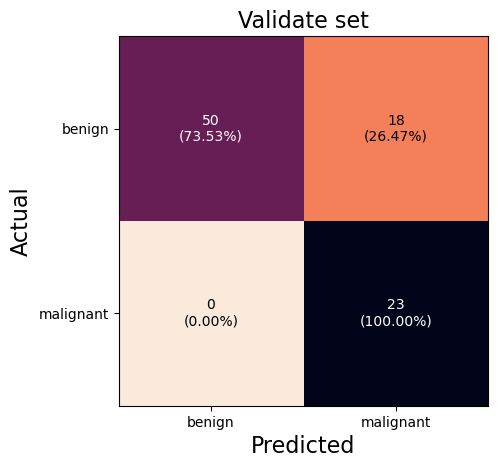

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 2 66]] 

----------------
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


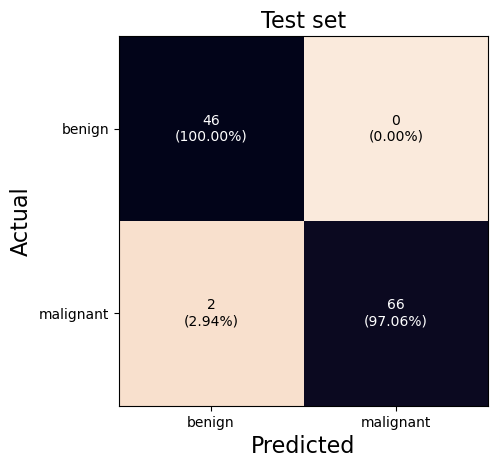

---------------------------------------
AUC validate: 0.8676
AUC test: 0.9853


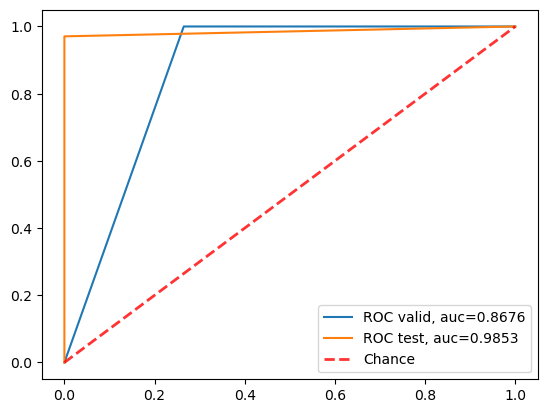

In [169]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split5 = sensitivity(cm_test)
spec_test_split5 = specificity(cm_test)
acc_test_split5 = accuracy(cm_test)
pre_test_split5 = precision(cm_test)
f1_test_split5 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split5 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split5)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split5))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split1

In [170]:
# setting split and path
split = 'split1'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(518, 32)
(518, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split1
train positive:    259
validate positive: 39


split1
############## validate set ################
Confusion Matrix
----------------
[[47  5]
 [ 1 38]] 

----------------
Sensitivity: 97.44%
Specificity: 90.38%
Accuracy: 93.41%
Precision: 88.37%
Sensitivity: 97.44%
Precision: 88.37%
F1: 92.68%


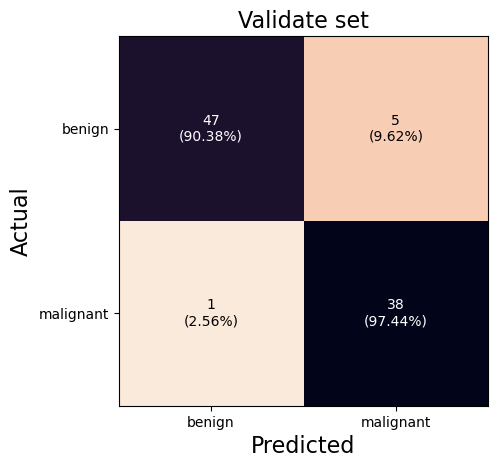

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 96.49%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


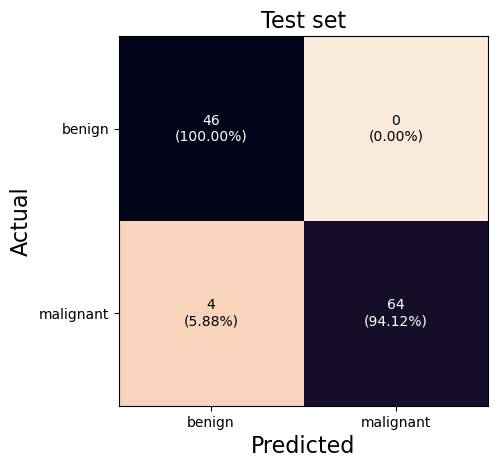

---------------------------------------
AUC validate: 0.9391
AUC test: 0.9706


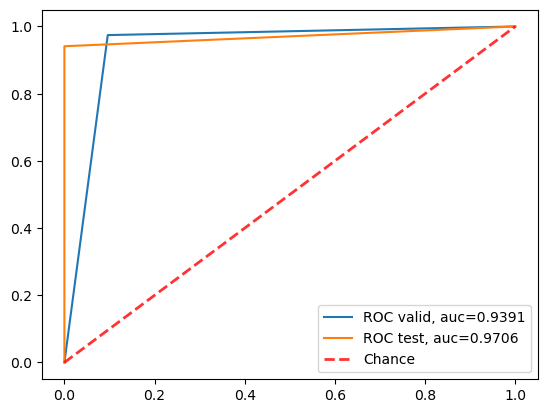

In [171]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split1 = sensitivity(cm_test)
spec_test_split1 = specificity(cm_test)
acc_test_split1 = accuracy(cm_test)
pre_test_split1 = precision(cm_test)
f1_test_split1 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split1 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split1)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split1))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split2

In [172]:
# setting split and path
split = 'split2'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(516, 32)
(516, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split2
train positive:    258
validate positive: 38


split2
############## validate set ################
Confusion Matrix
----------------
[[50  3]
 [ 2 36]] 

----------------
Sensitivity: 94.74%
Specificity: 94.34%
Accuracy: 94.51%
Precision: 92.31%
Sensitivity: 94.74%
Precision: 92.31%
F1: 93.51%


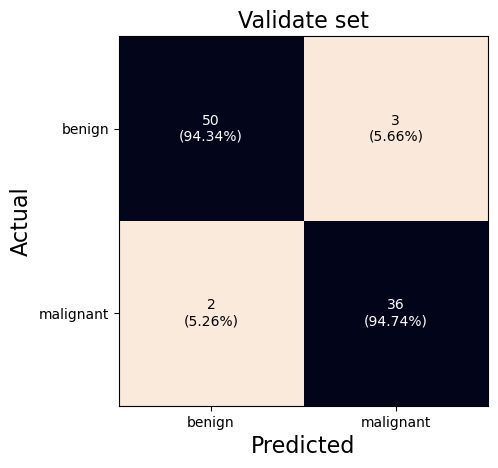

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 96.49%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


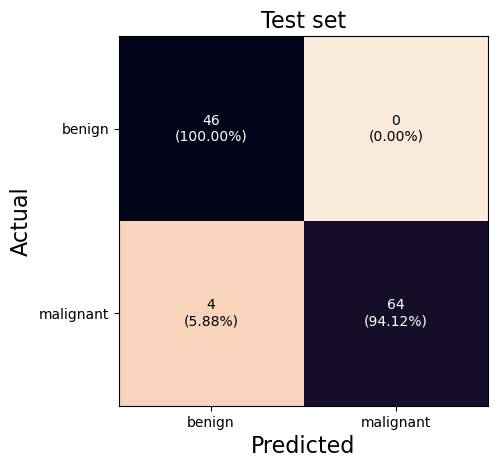

---------------------------------------
AUC validate: 0.9454
AUC test: 0.9706


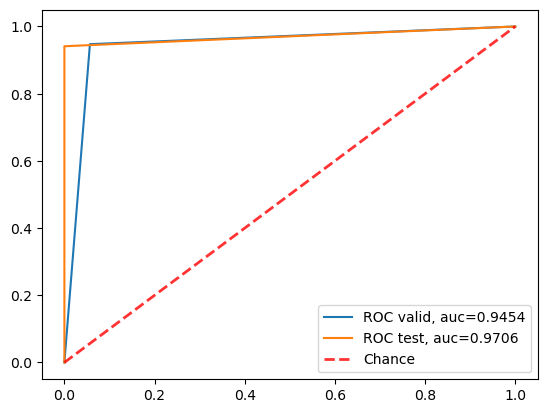

In [173]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split2 = sensitivity(cm_test)
spec_test_split2 = specificity(cm_test)
acc_test_split2 = accuracy(cm_test)
pre_test_split2 = precision(cm_test)
f1_test_split2 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split2 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split2)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split3

In [174]:
# setting split and path
split = 'split3'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(490, 32)
(490, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split3
train positive:    245
validate positive: 25


split3
############## validate set ################
Confusion Matrix
----------------
[[59  7]
 [ 1 24]] 

----------------
Sensitivity: 96.00%
Specificity: 89.39%
Accuracy: 91.21%
Precision: 77.42%
Sensitivity: 96.00%
Precision: 77.42%
F1: 85.71%


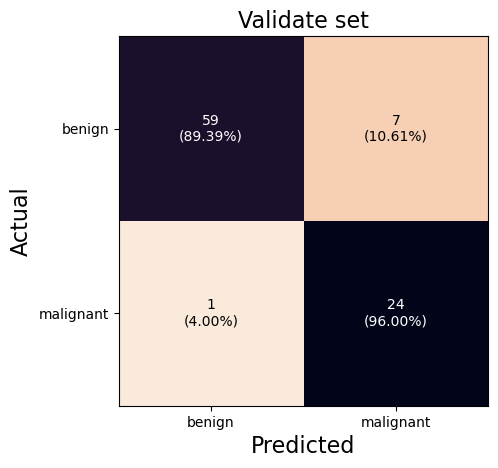

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 4 64]] 

----------------
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 96.49%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


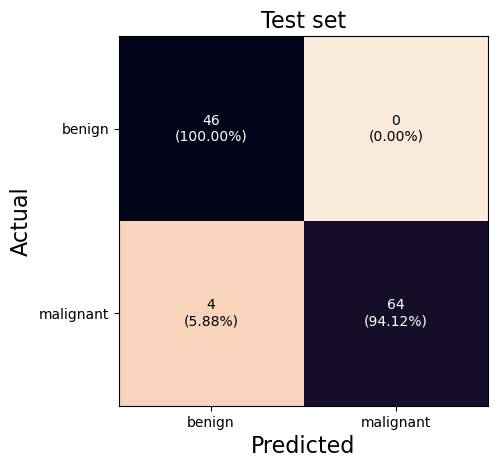

---------------------------------------
AUC validate: 0.9270
AUC test: 0.9706


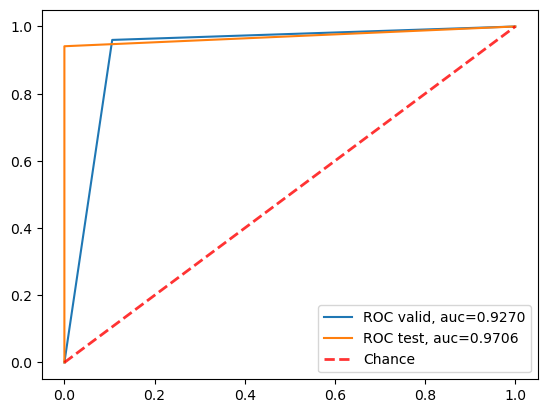

In [175]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split3 = sensitivity(cm_test)
spec_test_split3 = specificity(cm_test)
acc_test_split3 = accuracy(cm_test)
pre_test_split3 = precision(cm_test)
f1_test_split3 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split3 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split3)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split3))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

split4

In [176]:
# setting split and path
split = 'split4'
path = "../Anny_oversampling/DATA"
train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
test_path =  "{}/test.csv".format(path)
val_path = "{}/{}/val/val_{}.csv".format(path,split,split)

# Load the training set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the testing set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# Load the validation set
val_data = pd.read_csv(val_path)
print(val_data.shape)
x_val = val_data[val_data.columns[2:]]
print(x_val.shape)
y_val = val_data[val_data.columns[1]]
le = LabelEncoder()
y_val = np.array(le.fit_transform(y_val))
print(le.classes_)

# check balance in this split
print(split)
print("train positive:    " + str(sum(y_train)))
print("validate positive: " + str(sum(y_val)))

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

model.fit(x_train, y_train)

model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(split)

# Save the trained model to disk
joblib.dump(model, model_path)

# Load the saved model from disk
model = joblib.load(model_path)

(478, 32)
(478, 30)
['B' 'M']
(114, 33)
(114, 30)
['B' 'M']
(91, 32)
(91, 30)
['B' 'M']
split4
train positive:    239
validate positive: 19


split4
############## validate set ################
Confusion Matrix
----------------
[[54 18]
 [ 0 19]] 

----------------
Sensitivity: 100.00%
Specificity: 75.00%
Accuracy: 80.22%
Precision: 51.35%
Sensitivity: 100.00%
Precision: 51.35%
F1: 67.86%


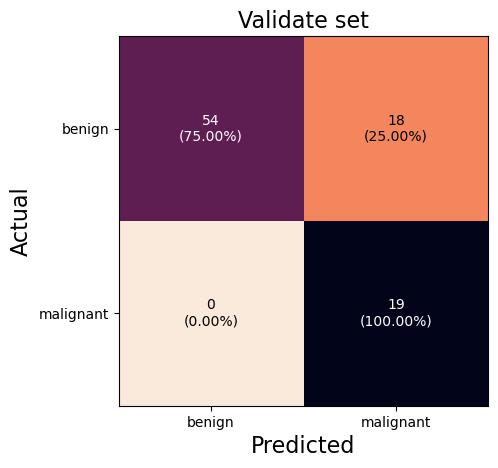

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [ 3 65]] 

----------------
Sensitivity: 95.59%
Specificity: 100.00%
Accuracy: 97.37%
Precision: 100.00%
Sensitivity: 95.59%
Precision: 100.00%
F1: 97.74%


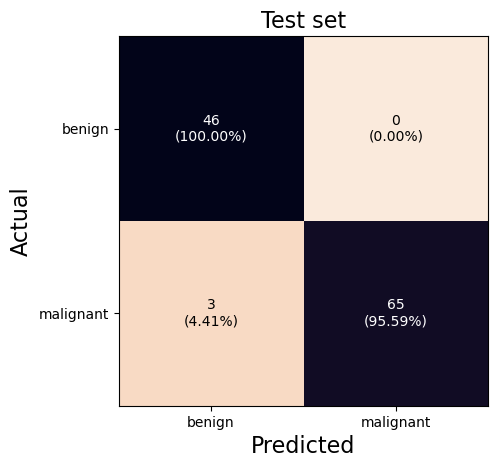

---------------------------------------
AUC validate: 0.8750
AUC test: 0.9779


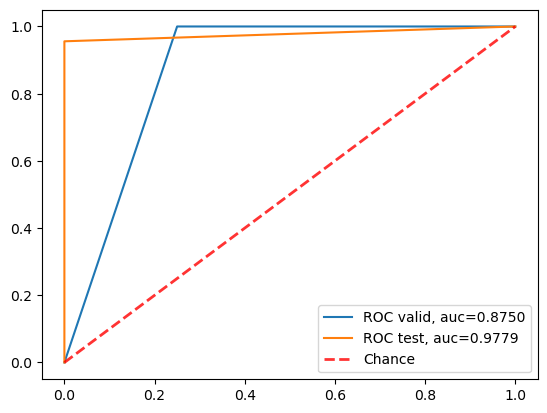

In [177]:
print(split)
############## validate set ################
print("############## validate set ################")
y_pred_val = model.predict(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_val = f1(cm_val)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black")
# Show plot
plt.show()

################# test set ##################
print("################# test set ##################")
y_pred_test = model.predict(x_test)


# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
sen_test_split4 = sensitivity(cm_test)
spec_test_split4 = specificity(cm_test)
acc_test_split4 = accuracy(cm_test)
pre_test_split4 = precision(cm_test)
f1_test_split4 = f1(cm_test)

# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")
# Show plot
plt.show()

################## plot ROC curve ########################
fpr1, tpr1, thr1 = roc_curve(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_test)
auc_test_split4 = roc_auc_score(y_test, y_pred_test)

print("---------------------------------------")
print("AUC validate: %.4f" % auc_val)
print("AUC test: %.4f" % auc_test_split4)

# plt.plot(fpr,tpr,label="data 1, auc="+str(auc),color='red')
plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc_val))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc_test_split4))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.legend(loc=4)
plt.show()
##########################################################

overall

In [178]:
sensitivity_values = []

sensitivity_values.append(sen_test_split1)
sensitivity_values.append(sen_test_split2)
sensitivity_values.append(sen_test_split3)
sensitivity_values.append(sen_test_split4)
sensitivity_values.append(sen_test_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

specificity_values = []

specificity_values.append(spec_test_split1)
specificity_values.append(spec_test_split2)
specificity_values.append(spec_test_split3)
specificity_values.append(spec_test_split4)
specificity_values.append(spec_test_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

accuracy_values = []

accuracy_values.append(acc_test_split1)
accuracy_values.append(acc_test_split2)
accuracy_values.append(acc_test_split3)
accuracy_values.append(acc_test_split4)
accuracy_values.append(acc_test_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

precision_values = []

precision_values.append(pre_test_split1)
precision_values.append(pre_test_split2)
precision_values.append(pre_test_split3)
precision_values.append(pre_test_split4)
precision_values.append(pre_test_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

f1_values = []

f1_values.append(f1_test_split1)
f1_values.append(f1_test_split2)
f1_values.append(f1_test_split3)
f1_values.append(f1_test_split4)
f1_values.append(f1_test_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

auc_values = []

auc_values.append(auc_test_split1)
auc_values.append(auc_test_split2)
auc_values.append(auc_test_split3)
auc_values.append(auc_test_split4)
auc_values.append(auc_test_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc, auc_sd))

[94.11764705882352, 94.11764705882352, 94.11764705882352, 95.58823529411765, 97.05882352941177]
Mean Sensitivity: 95.0
Sensitivity Standard Deviation: 1.3153341044116467
Overall Sensitivity: 95.00 ± 1.32%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean Specificity: 100.0
Specificity Standard Deviation: 0.0
Overall Specificity: 100.00 ± 0.00%
[96.49122807017544, 96.49122807017544, 96.49122807017544, 97.36842105263158, 98.24561403508771]
Mean accuracy: 97.01754385964912
accuracy Standard Deviation: 0.784585255263081
Overall accuracy: 97.02 ± 0.78%
[100.0, 100.0, 100.0, 100.0, 100.0]
Mean precision: 100.0
precision Standard Deviation: 0.0
Overall precision: 100.00 ± 0.00%
[96.96969696969695, 96.96969696969695, 96.96969696969695, 97.74436090225565, 98.50746268656717]
Mean f1: 97.43218289958274
f1 Standard Deviation: 0.6883606307156662
Overall f1: 97.43 ± 0.69%
[0.9705882352941176, 0.9705882352941176, 0.9705882352941176, 0.9779411764705883, 0.9852941176470589]
Mean auc: 0.975
auc Standard Deviatio